In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import helper_functions

EPOCHS = 40
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001

## Extracting and Preparing Data

In [6]:
# load dataset
train_data = helper_functions.load_data()

X = np.array(train_data['mfccs'], dtype=float)
y = np.array([helper_functions.one_hot_to_label(label) for label in train_data['classes']])
y_train_one_hot = np.array(train_data['classes'])
y = y_train_one_hot
print(y)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [9]:
# create train/validation/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1)

# convert inputs which are 2 dimensional MFCC arrays into 3 dimensional arrays
# Currently shape of the arrays is (# segments, 13), we want to add a 3rd dimension so we have (# segments, 13, 1)
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

n_dim = X_train.shape[2]

print(f'x_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'n_dim: {n_dim}')

x_train shape: (52423, 15, 173, 1)
y_train shape: (52423, 12)
n_dim: 173


## Building and Training The Model

In [26]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# build network architecture using convolutional layers
model = tf.keras.models.Sequential()

# 1st conv layer
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# 2nd conv layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# 3rd conv layer
model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

# flatten output and feed into dense layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))


# softmax output layer
model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [27]:
from keras.metrics import FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall

optimiser = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

# compile model
model.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=['accuracy', FalsePositives(), FalseNegatives(), TruePositives(), TrueNegatives(), Precision(), Recall()])

# print model parameters on console
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 13, 171, 64)       640       
_________________________________________________________________
batch_normalization_15 (Batc (None, 13, 171, 64)       256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 86, 64)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 5, 84, 32)         18464     
_________________________________________________________________
batch_normalization_16 (Batc (None, 5, 84, 32)         128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 3, 42, 32)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 2, 41, 32)        

In [28]:
print(y_train[0].shape)

(12,)


In [29]:
# train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 3)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_validation, y_validation), callbacks = [callback])
history = history.history # discard training params - unnecessary

Epoch 1/40
1639/1639 [==============================] - 112s 67ms/step - loss: 1.2569 - accuracy: 0.6625 - false_positives_4: 5074.1367 - false_negatives_4: 12677.8770 - true_positives_4: 13562.1074 - true_negatives_4: 283565.6562 - precision_4: 0.6979 - recall_4: 0.4853 - val_loss: 0.9164 - val_accuracy: 0.7265 - val_false_positives_4: 9734.6826 - val_false_negatives_4: 24924.5801 - val_true_positives_4: 30442.2520 - val_true_negatives_4: 599300.5625 - val_precision_4: 0.7576 - val_recall_4: 0.5498
Epoch 2/40
1639/1639 [==============================] - 112s 68ms/step - loss: 0.7790 - accuracy: 0.7752 - false_positives_4: 13379.9951 - false_negatives_4: 34572.1953 - true_positives_4: 49915.8125 - true_negatives_4: 915987.6875 - precision_4: 0.7860 - recall_4: 0.5874 - val_loss: 0.6809 - val_accuracy: 0.8019 - val_false_positives_4: 16750.4980 - val_false_negatives_4: 42901.1250 - val_true_positives_4: 70713.7031 - val_true_negatives_4: 1233012.8750 - val_precision_4: 0.8085 - val_reca

1639/1639 [==============================] - 108s 66ms/step - loss: 0.1908 - accuracy: 0.9564 - false_positives_4: 64969.1758 - false_negatives_4: 131347.5938 - true_positives_4: 826860.0000 - true_negatives_4: 10475317.0000 - precision_4: 0.9271 - recall_4: 0.8629 - val_loss: 0.3357 - val_accuracy: 0.9104 - val_false_positives_4: 66054.2188 - val_false_negatives_4: 133055.1094 - val_true_positives_4: 854279.6875 - val_true_negatives_4: 10794629.0000 - val_precision_4: 0.9282 - val_recall_4: 0.8652
Epoch 18/40
1639/1639 [==============================] - 117s 72ms/step - loss: 0.1810 - accuracy: 0.9598 - false_positives_4: 67038.6562 - false_negatives_4: 134609.6562 - true_positives_4: 881846.0625 - true_negatives_4: 11113976.0000 - precision_4: 0.9293 - recall_4: 0.8676 - val_loss: 0.3006 - val_accuracy: 0.9214 - val_false_positives_4: 68039.7344 - val_false_negatives_4: 136199.1719 - val_true_positives_4: 909383.6250 - val_true_negatives_4: 11433371.0000 - val_precision_4: 0.9304 - v

## Saving and Loading The Model

In [11]:
from os import path
import pickle

model_dir = 'models/ross_cnn'
history_path = 'models/ross_cnn_history'

def save_model(override=False):
    if override or not path.exists(model_dir):
        model.save(model_dir)
def save_history(override=False):
    if override or not path.exists(history_path):
        file = open(history_path, 'wb')
        pickle.dump(history, file)
        file.close()

In [31]:
save_model(override=True)
save_history(override=True)

INFO:tensorflow:Assets written to: models/ross_cnn\assets


In [12]:
# Check if model exists
# If not, loaded from saved
if (not 'model' in locals() or model == None):
    if path.exists(model_dir):
        model = tf.keras.models.load_model(model_dir)
    else:
        raise ValueError('Model doesn\'t exist and cannot be recovered from disk.')
else:
    print('Model already loaded.')

AttributeError: 'FalsePositives' object has no attribute '_serialized_attributes'

In [33]:
# Also load history for plotting
if (not 'history' in locals() or history == None):
    if path.exists(history_path):
        file = open(history_path, "rb")
        history = pickle.load(file)
        file.close()
    else:
        raise ValueError('History doesn\'t exist and cannot be recovered from disk.')
else:
    print('History already loaded.')

History already loaded.


## Evaluation

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set()

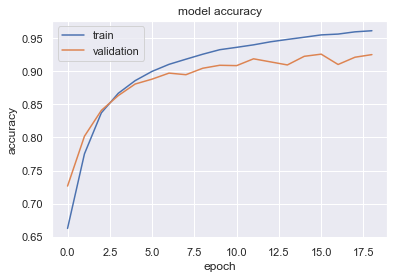

In [35]:
# Show history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

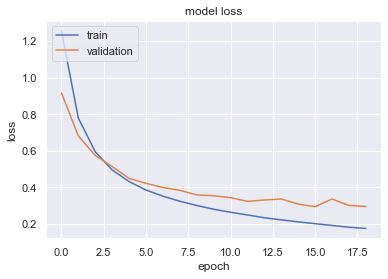

In [36]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Confusion Matrix

In [44]:
# First let the model predict
y_pred = model.predict(X_test)
model.evaluate(X_test, y_test)

203/203 [==============================] - 3s 15ms/step - loss: 0.3060 - accuracy: 0.9224 - false_positives_4: 70290.2734 - false_negatives_4: 139671.7969 - true_positives_4: 970304.1875 - true_negatives_4: 12139443.0000 - precision_4: 0.9325 - recall_4: 0.8742


[0.30597373843193054,
 0.9224470853805542,
 70290.2734375,
 139671.796875,
 970304.1875,
 12139443.0,
 0.9324515461921692,
 0.8741667866706848]

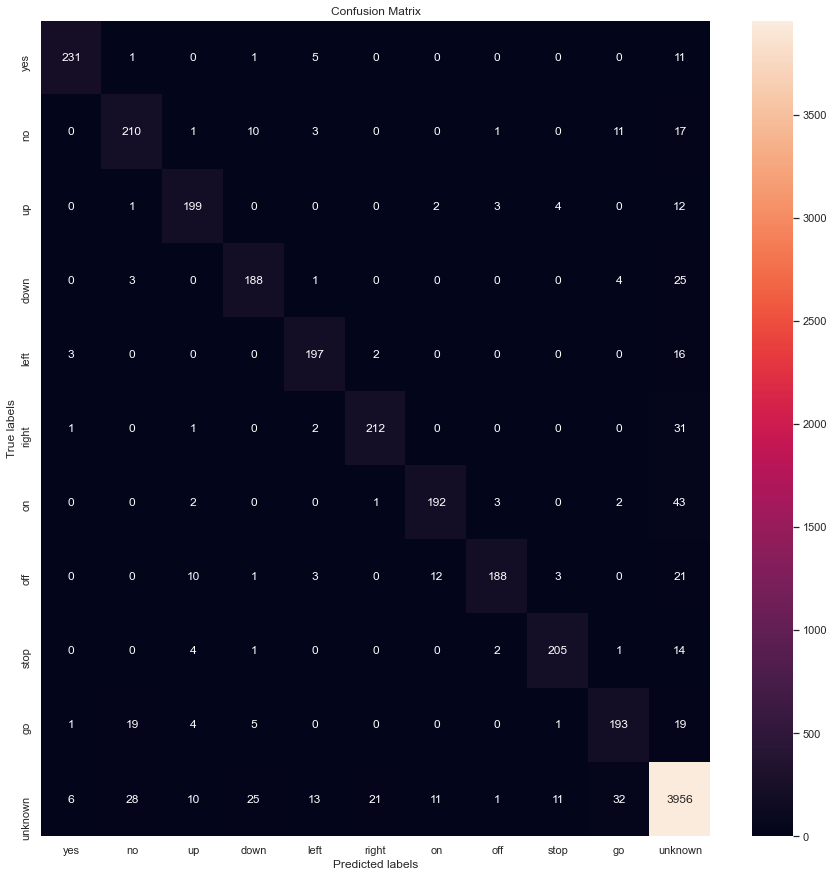

In [40]:
# Then calculate the confusion matrix based on predictions
y_test_cm = y_test.argmax(axis=1)
y_pred_cm = y_pred.argmax(axis=1)
cm = confusion_matrix(y_test_cm, y_pred_cm)

fig_dim = 15
fig_size = (fig_dim, fig_dim)
fig, ax = plt.subplots(figsize=fig_size)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
PermitedLabels = ['yes','no','up','down','left','right','on','off','stop','go','unknown']
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(PermitedLabels); ax.yaxis.set_ticklabels(PermitedLabels);

Average precision score, micro-averaged over all classes: 0.98


c:\python39\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
c:\python39\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.97622')

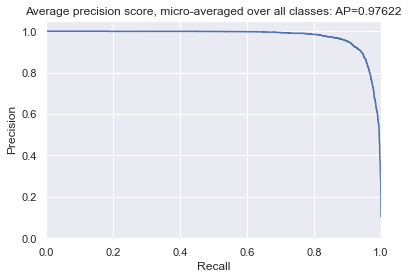

In [41]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()
for i in range(12):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred,average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.5f}'
    .format(average_precision["micro"]))